# Electric Vehicle Growth Prediction — Model Training & Evaluation

This notebook loads the cleaned area-level dataset, trains classification models
using scikit-learn's **fit** / **predict**, evaluates them, visualizes results with matplotlib,
and produces a ranked list of tracts by predicted growth likelihood.

## Step 0 — Imports

In [24]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

import joblib

if Path.cwd().name == "notebooks":
    os.chdir(Path.cwd().parent)
print("Working directory set to:", Path.cwd())
print("data folder contents:", os.listdir("data"))

pd.set_option("display.max_columns", 50)
print("Versions -> pandas:", pd.__version__)

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

def save_fig(filename):
    os.makedirs("figures", exist_ok=True)
    plt.savefig(os.path.join("figures", filename))

Working directory set to: C:\Users\Agree\Desktop\electric-vehicle-growth-prediction
data folder contents: ['.ipynb_checkpoints', 'cleaned_ev_area_data.csv', 'cleaned_ev_area_data_scored.csv', 'top_growth_tracts.csv']
Versions -> pandas: 2.2.3


## Step 1 — Load cleaned area-level dataset

In [25]:
# Adjust the path if your file lives elsewhere
candidate_paths = [
    "data/cleaned_ev_area_data.csv",
    "./cleaned_ev_area_data.csv"
]
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break
else:
    raise FileNotFoundError("Could not find cleaned_ev_area_data.csv in data/ or current folder.")

area_df = pd.read_csv(data_path)
print("Loaded:", data_path, "| shape:", area_df.shape)
area_df.head()

Loaded: data/cleaned_ev_area_data.csv | shape: (2328, 7)


,2020_census_tract,vehicle_count,electric_range,base_msrp,model_year,percent_bev,high_adoption
0,1.001020e+09,2,19.5,0.0,2022.0,0.5,0
1,1.001021e+09,1,25.0,0.0,2022.0,0.0,0
2,1.045020e+09,1,0.0,0.0,2023.0,1.0,0
3,1.081042e+09,1,220.0,0.0,2019.0,1.0,0
4,1.117031e+09,1,259.0,0.0,2020.0,1.0,0


## Step 2 — Define features (X) and target (y)

In [26]:
# Features should match what you built during preprocessing
features = ["electric_range", "base_msrp", "model_year", "percent_bev"]
target = "high_adoption"

missing = [c for c in features + [target] if c not in area_df.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}")

X = area_df[features].copy()
y = area_df[target].astype(int).copy()

print("Feature preview:")
display(X.head())
print("Target balance:")
display(y.value_counts())

Feature preview:


,electric_range,base_msrp,model_year,percent_bev
0,19.5,0.0,2022.0,0.5
1,25.0,0.0,2022.0,0.0
2,0.0,0.0,2023.0,1.0
3,220.0,0.0,2019.0,1.0
4,259.0,0.0,2020.0,1.0


Target balance:


high_adoption
0    1168
1    1160
Name: count, dtype: int64

## Step 3 — Standardize features for logistic regression

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled shape:", X_scaled.shape)

Scaled shape: (2328, 4)


## Step 4 — Train/Test split

In [28]:
X_train_s, X_test_s, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

# Keep also an unscaled split for tree models (same indices to compare fairly)
X_train, X_test, _, _ = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

len(X_train), len(X_test), y_train.mean(), y_test.mean()

(1862, 466, np.float64(0.4983888292158969), np.float64(0.4978540772532189))

## Step 5 — Baseline model: Logistic Regression (fit / predict)

In [29]:
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train_s, y_train)  # <-- FIT

y_pred_log = logit.predict(X_test_s)             # <-- PREDICT labels
y_prob_log = logit.predict_proba(X_test_s)[:,1]  # <-- PREDICT probabilities

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, digits=3))

# Coefficients table
coef_tbl = pd.DataFrame({"feature": features, "coef": logit.coef_[0]}).sort_values("coef", ascending=False)
coef_tbl

Logistic Regression
Accuracy: 0.6072961373390557
ROC AUC: 0.6300655761862658
Confusion matrix:
 [[143  91]
 [ 92 140]]
              precision    recall  f1-score   support

           0      0.609     0.611     0.610       234
           1      0.606     0.603     0.605       232

    accuracy                          0.607       466
   macro avg      0.607     0.607     0.607       466
weighted avg      0.607     0.607     0.607       466



,feature,coef
2,model_year,0.322091
3,percent_bev,0.236077
1,base_msrp,0.054814
0,electric_range,0.002849


## Step 6 — Stronger model: Random Forest (fit / predict)

In [30]:
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # <-- FIT (trees don't need scaling)

y_pred_rf = rf.predict(X_test)                 # <-- PREDICT labels
y_prob_rf = rf.predict_proba(X_test)[:, 1]     # <-- PREDICT probabilities

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

imp_tbl = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
imp_tbl

Random Forest
Accuracy: 0.8240343347639485
ROC AUC: 0.9300766283524904
Confusion matrix:
 [[195  39]
 [ 43 189]]
              precision    recall  f1-score   support

           0      0.819     0.833     0.826       234
           1      0.829     0.815     0.822       232

    accuracy                          0.824       466
   macro avg      0.824     0.824     0.824       466
weighted avg      0.824     0.824     0.824       466



,feature,importance
1,base_msrp,0.421404
3,percent_bev,0.255043
0,electric_range,0.168344
2,model_year,0.155208


## Step 7 — ROC curve (matplotlib)

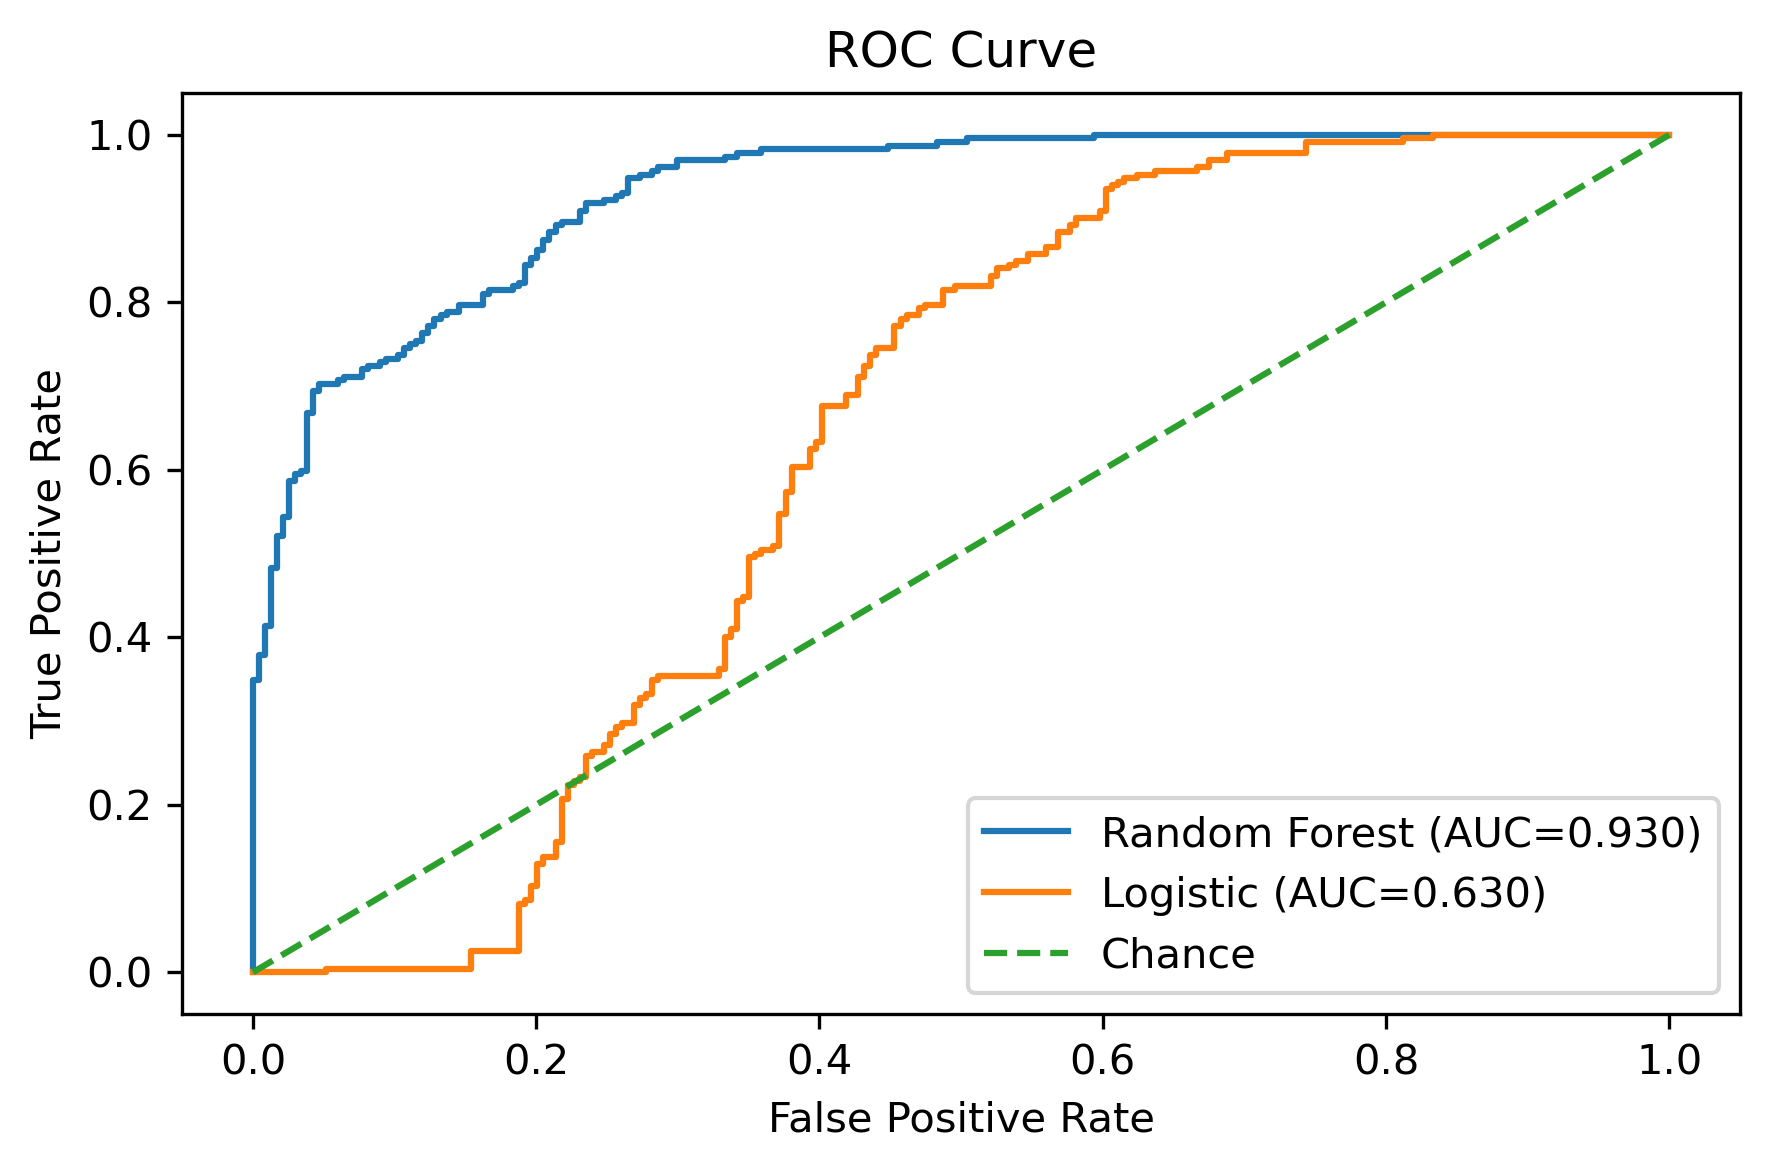

<Figure size 1920x1440 with 0 Axes>

In [31]:
plt.figure(figsize=(6,4))

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")

# Logistic
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.3f})")

# Chance
plt.plot([0,1],[0,1], linestyle="--", label="Chance")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()
save_fig("roc_comparison.png")

## Step 8 — Confusion matrices (matplotlib)

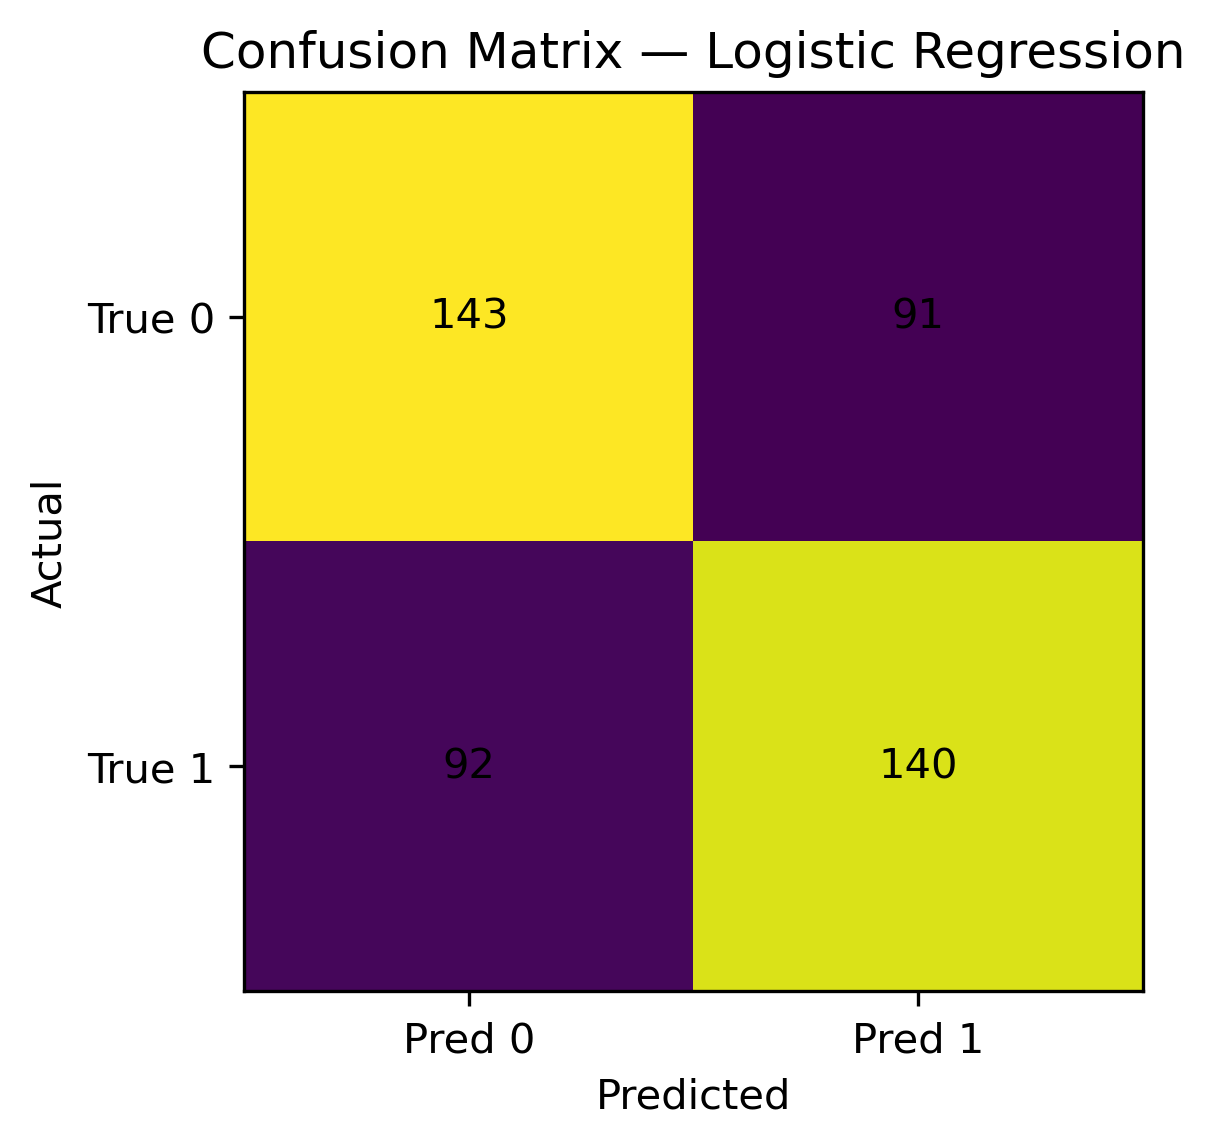

<Figure size 1920x1440 with 0 Axes>

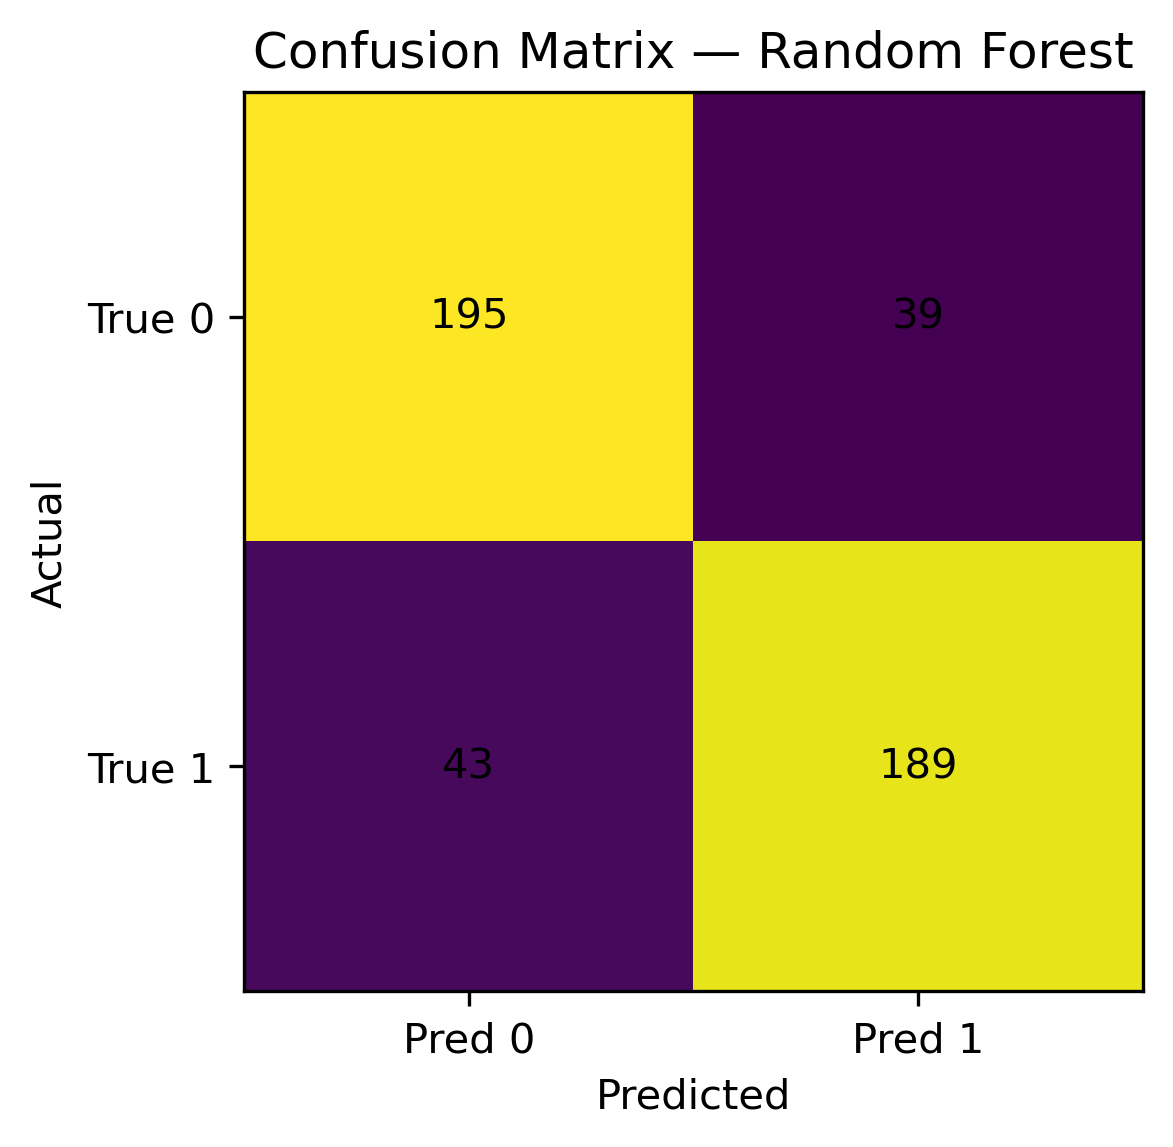

<Figure size 1920x1440 with 0 Axes>

In [32]:
def plot_cm(cm, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    save_fig("confusion_matrix_rf.png")

cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

plot_cm(cm_log, "Confusion Matrix — Logistic Regression")
plot_cm(cm_rf,  "Confusion Matrix — Random Forest")

## Step 9 — Feature importance (Random Forest)

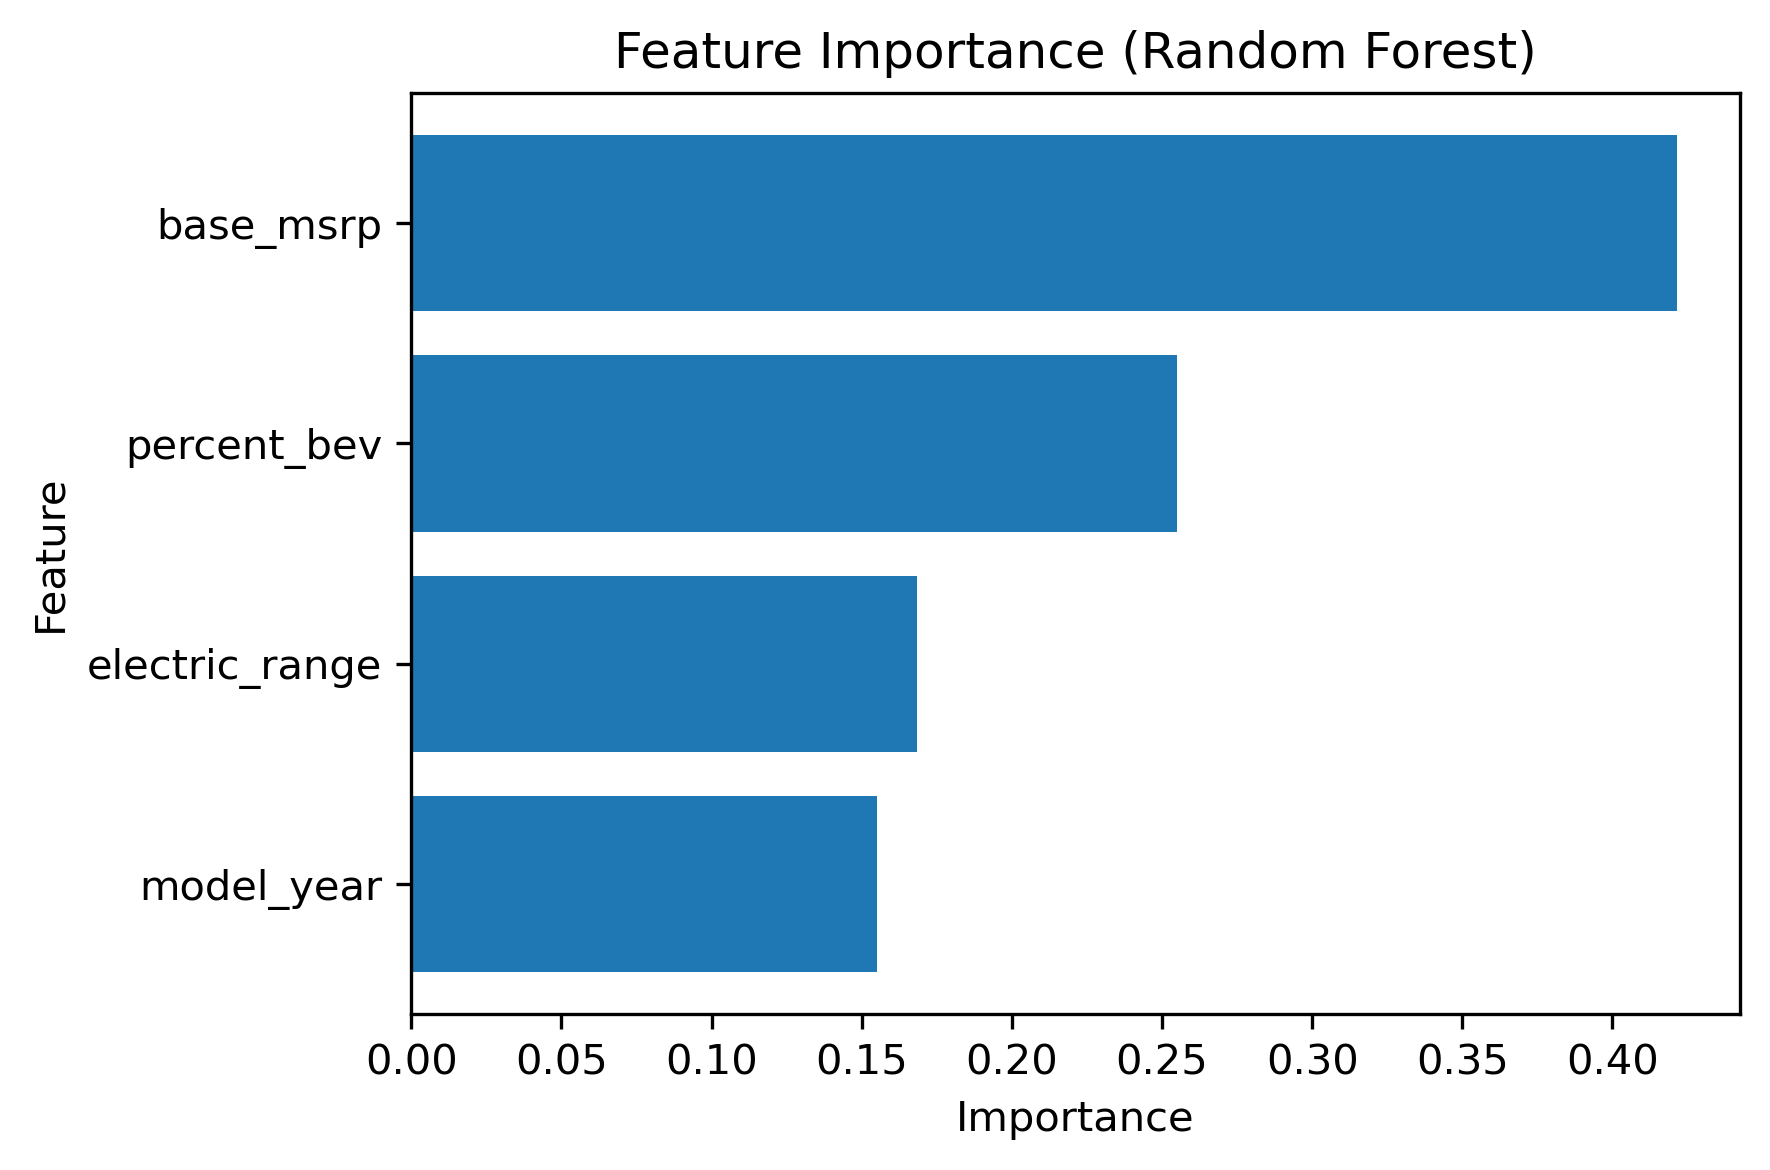

<Figure size 1920x1440 with 0 Axes>

In [33]:
imp_sorted = imp_tbl.sort_values("importance", ascending=True)
plt.figure(figsize=(6,4))
plt.barh(imp_sorted["feature"], imp_sorted["importance"])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
save_fig("feature_importance.png")

## Step 10 — Rank all tracts by growth likelihood

In [34]:
# Use RF since it performed best
area_df["growth_likelihood"] = rf.predict_proba(area_df[features])[:, 1]

topN = (area_df
        .sort_values("growth_likelihood", ascending=False)
        .head(20)
        [["2020_census_tract", "growth_likelihood", "vehicle_count", *features]]
       )
topN

,2020_census_tract,growth_likelihood,vehicle_count,electric_range,base_msrp,model_year,percent_bev
1394,5.303303e+10,1.0,503,41.622266,589.662028,2022.131213,0.906561
1609,5.305307e+10,1.0,224,31.665179,743.973214,2022.611607,0.816964
1608,5.305307e+10,1.0,659,29.230653,414.946889,2022.663126,0.845220
1134,5.303302e+10,1.0,484,39.291322,464.152893,2022.123967,0.882231
1133,5.303302e+10,1.0,423,33.973995,107.801418,2022.524823,0.886525
1132,5.303302e+10,1.0,587,41.391823,299.395230,2022.313458,0.851789
1121,5.303302e+10,1.0,504,43.882937,271.517857,2022.083333,0.863095
1116,5.303302e+10,1.0,310,37.700000,412.258065,2022.006452,0.812903
1115,5.303302e+10,1.0,370,31.602703,418.243243,2022.221622,0.840541
1114,5.303302e+10,1.0,298,39.583893,682.046980,2021.932886,0.842282


## Step 11 — Save model and outputs

In [35]:
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

joblib.dump(rf, "models/random_forest_growth_model.joblib")
area_df.to_csv("data/cleaned_ev_area_data_scored.csv", index=False)
topN.to_csv("data/top_growth_tracts.csv", index=False)

print("Saved model -> models/random_forest_growth_model.joblib")
print("Saved scored data -> data/cleaned_ev_area_data_scored.csv")
print("Saved top-N tracts -> data/top_growth_tracts.csv")

Saved model -> models/random_forest_growth_model.joblib
Saved scored data -> data/cleaned_ev_area_data_scored.csv
Saved top-N tracts -> data/top_growth_tracts.csv
